In [1]:
shh<-suppressMessages
shh(library(tidyverse))
shh(library(caret))
shh(library(reshape2))
shh(library(Amelia))
trainset<-read.csv("../input/data_set_ALL_AML_train.csv",stringsAsFactors = F,quote = "")
head(trainset,10) 

Warning message:
“replacing previous import ‘ggplot2::empty’ by ‘plyr::empty’ when loading ‘caret’”

Gene.Description,Gene.Accession.Number,X1,call,X2,call.1,X3,call.2,X4,call.3,⋯,X29,call.33,X30,call.34,X31,call.35,X32,call.36,X33,call.37
AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,⋯,15,A,-318,A,-32,A,-124,A,-135,A
AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,⋯,-114,A,-192,A,-49,A,-79,A,-186,A
AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,⋯,2,A,-95,A,49,A,-37,A,-70,A
AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,⋯,193,A,312,A,230,P,330,A,337,A
AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,⋯,-51,A,-139,A,-367,A,-188,A,-407,A
AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-5_at,-558,A,-400,A,-650,A,-585,A,⋯,-155,A,-344,A,-508,A,-423,A,-566,A
AFFX-BioDn-3_at (endogenous control),AFFX-BioDn-3_at,199,A,-330,A,33,A,158,A,⋯,29,A,324,A,-349,A,-31,A,-141,A
AFFX-CreX-5_at (endogenous control),AFFX-CreX-5_at,-176,A,-168,A,-367,A,-253,A,⋯,-105,A,-237,A,-194,A,-223,A,-315,A
AFFX-CreX-3_at (endogenous control),AFFX-CreX-3_at,252,A,101,A,206,A,49,A,⋯,42,A,105,A,34,A,-82,A,206,A
AFFX-BioB-5_st (endogenous control),AFFX-BioB-5_st,206,A,74,A,-215,A,31,A,⋯,524,A,167,A,-56,A,176,A,321,A


**Reshaping the Data ** 

In [2]:
#Replace everything that starts with X as some other name. Number
#Num is the experiment number?
colnames(trainset)<-gsub("X{1,}","Num",colnames(trainset))
trainset<-trainset %>% 
 select(-contains("call"),-Gene.Description) %>% 
  melt(id.vars="Gene.Accession.Number") %>% 
  spread(Gene.Accession.Number,value) %>% 
  rename(ExptNo.=variable) 
#Find Missing values 

**Is there any Missing Data? ** 

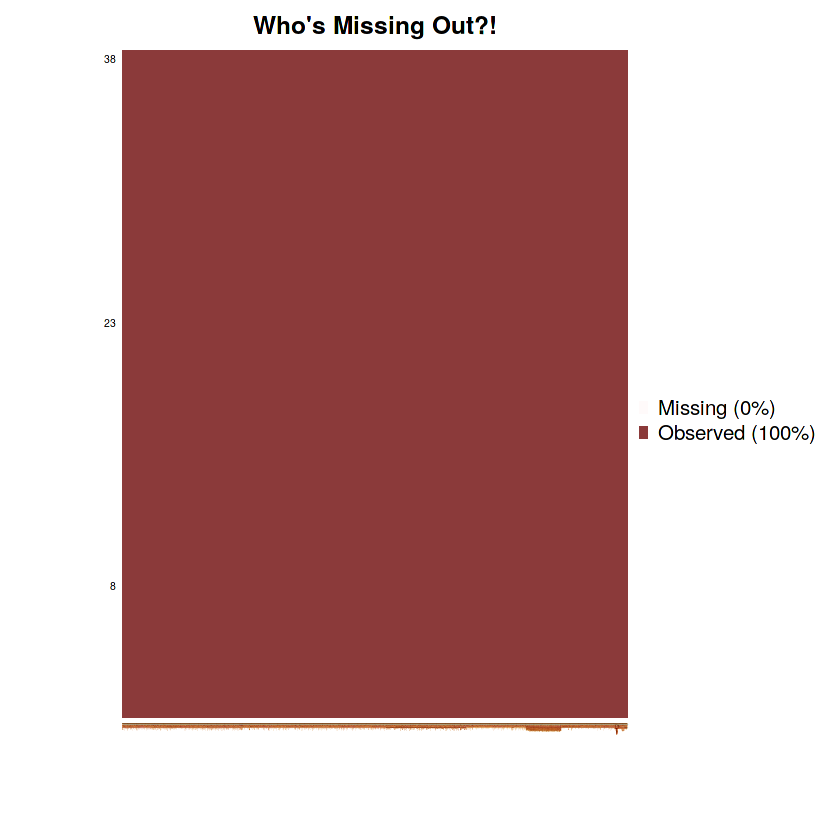

In [3]:
missmap(trainset,col=c("snow","indianred4"),main="Who's Missing Out?!",x.cex=0.000000000003,
       y.cex=0.5)   
      

We interestingly have no missing data in our data.

**Loading Actual Data**

In [4]:
#dataset contains no missing values
#Load patient data and cancer type
actual<-read.csv("../input/actual.csv",stringsAsFactors = F,quote="")
#Susbset data for first 72 patients
trainme<-trainset[1:72,]
#bind to training set
patientdata<-cbind(trainme,actual)
patientdata<-patientdata %>% 
  select(patient,cancer,everything()) %>% 
  mutate(patient=as.factor(patient),cancer=as.factor(cancer))
training<-patientdata %>% 
  filter(!is.na(ExptNo.)) 

**Visualization and Some Observations from the Data**

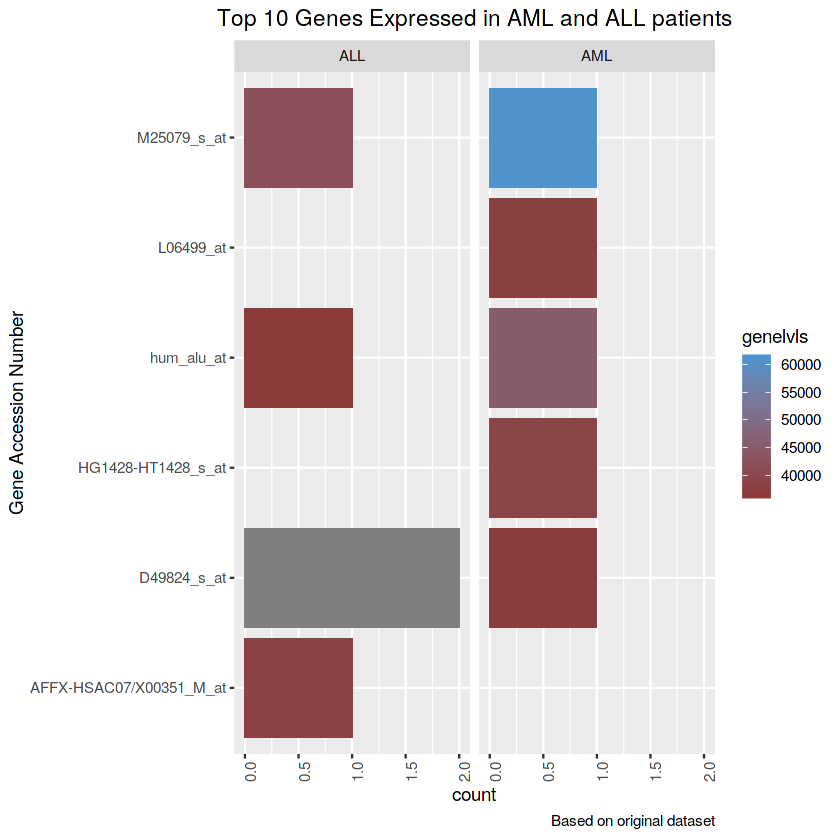

In [5]:
#In this part, I'll visualize the expression levels. Since the dataset is huge, 
#we've only visualised the top 10 genes expressed. 
shh(patientdata %>% 
select(-ExptNo.) %>% 
  gather("id","value",3:ncol(.)) %>% 
 mutate(GeneAccNum=as.factor(id),genelvls=value) %>% 
  select(-id,-value) %>% 
  filter(!is.na(genelvls)) %>% 
  top_n(10) %>% 
ggplot(aes(GeneAccNum))+geom_bar(aes(fill=genelvls))+
  theme(axis.text.x = element_text(angle=90),
plot.title = element_text(hjust=0.5))+facet_wrap(~cancer)+
  ggtitle("Top 10 Genes Expressed in AML and ALL patients")+
  labs(x="Gene Accession Number",caption="Based on original dataset")+
  coord_flip()+
  scale_fill_continuous(low="indianred4",high = "steelblue3"))  

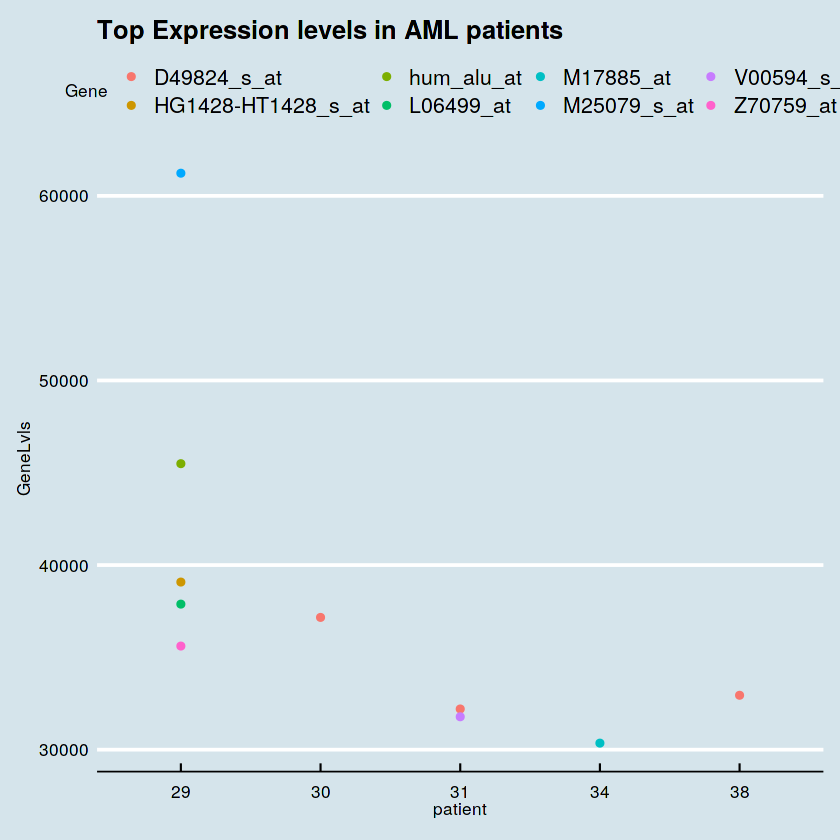

In [6]:
shh(require(ggthemes))
patientdata %>% 
filter(cancer=="AML") %>% 
select(-ExptNo.) %>% 
gather("id","value",3:ncol(.)) %>% 
rename(Gene=id,GeneLvls=value) %>% 
filter(!is.na(GeneLvls)) %>% 
top_n(10,GeneLvls) %>% 
ggplot(aes(patient,GeneLvls,col=Gene))+geom_point()+
theme_economist()+ggtitle("Top Expression levels in AML patients")



Training our Models

In [7]:
#First partition the data into a training and validating dataset.
training<-training %>% 
         select(-patient,-ExptNo.)
traincanc<-createDataPartition(training$cancer,p=0.85,list=F)
validatecanc<-training[-traincanc,]
traincanc<-training[traincanc,]
#Setup metric and control. We'll use accuracy as our metric
control<-trainControl(method="repeatedcv",number=10,repeats = 3)
metric<-"Accuracy"
#Set up models
set.seed(233)
fit.svm1<-train(cancer~.,data=traincanc,method="svmRadial",trControl=control,metric=metric,
                verbose=F)
set.seed(233)
fit.knn1<-train(cancer~.,data=traincanc,method="knn",trControl=control,metric=metric)
set.seed(233)
fit.rf1<-train(cancer~.,data=traincanc,method="rf",trControl=control,metric=metric,
               verbose=F)
set.seed(233)
gbm_grid<-expand.grid(
n.trees=5,
interaction.depth=3,
shrinkage=0.03,
n.minobsinnode=2)
fit.gbm<-train(cancer~.,data=traincanc,method="gbm",trControl=control,metric=metric,
               tuneGrid=gbm_grid,verbose=F)
result<-resamples(list(rf=fit.rf1,svm=fit.svm1,knn=fit.knn1,gbm=fit.gbm)) 

**Result of our Training. **

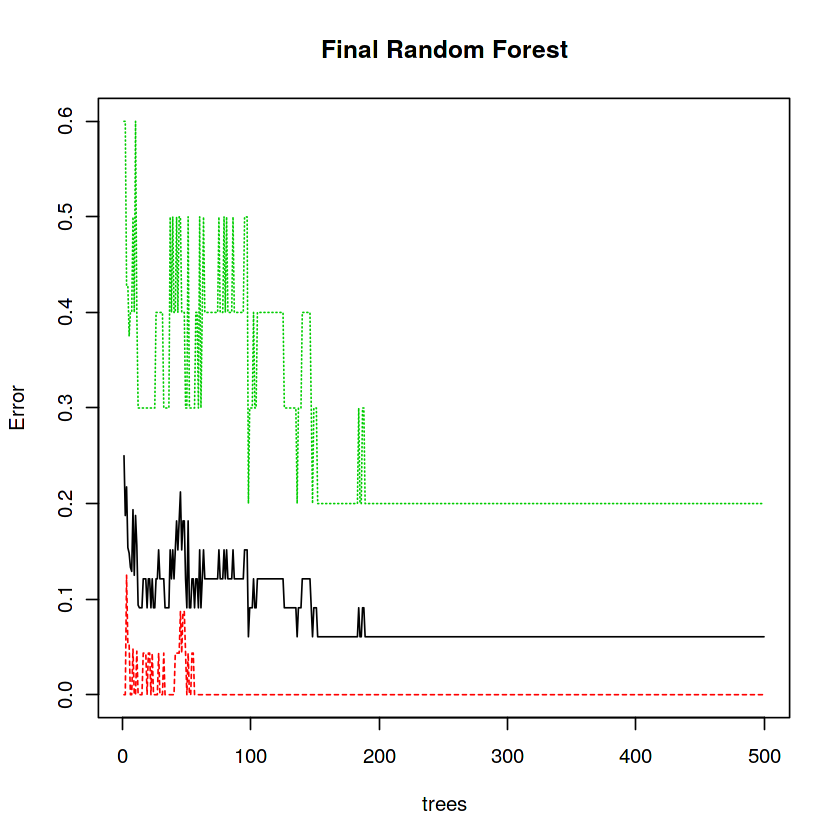

In [8]:
plot(fit.rf1$finalModel,main="Final Random Forest")

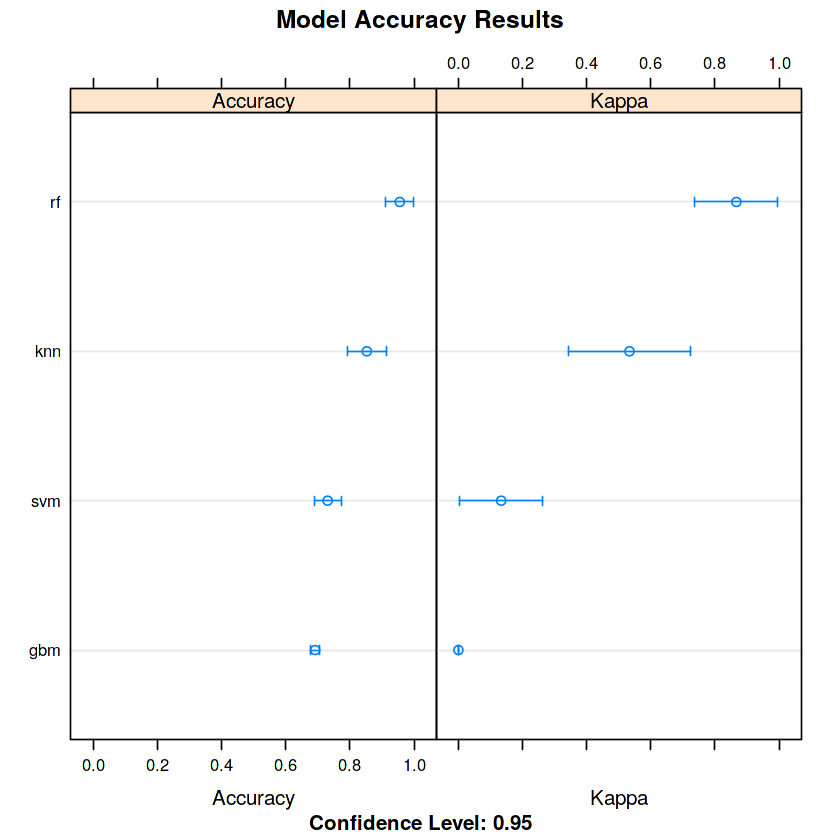

In [9]:
dotplot(result,main="Model Accuracy Results")  



From the plot, we can conclude that the random forest is the best model for prediction. However, we'll need to test this on a validation data set to see how well it works on "unseen" data. 

**Validation Results**

In [10]:
predictcanc<-predict(fit.rf1,validatecanc)
cm12<-confusionMatrix(predictcanc,validatecanc$cancer)
cm12$overall

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
     1.0000000      1.0000000      0.4781762      1.0000000      0.8000000 
AccuracyPValue  McnemarPValue 
     0.3276800            NaN

**Comparison With Experimental Data**
The model does a pretty good job.